# EV presence and consumption

Authors: Alessio Carnevale, Manuel Cattoni

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data/ev_dataset.csv', delimiter=';')

This [dataset](https://data.4tu.nl/datasets/80ef3824-3f5d-4e45-8794-3b8791efbd13/1) collects 55,000 unique charging sessions from a large public parking lot in Utrecht.

In [3]:
print("Length of Dataset:", len(df))
df.info()

Length of Dataset: 55379
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55379 entries, 0 to 55378
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   EV_id_x                    55379 non-null  object 
 1   start_datetime             55379 non-null  object 
 2   end_datetime               55379 non-null  object 
 3   total_energy               55379 non-null  float64
 4   rail                       55379 non-null  object 
 5   evse_uid                   55379 non-null  int64  
 6   channel                    55379 non-null  int64  
 7   capacity_kwh               3829 non-null   float64
 8   commute_km_range_min       4053 non-null   float64
 9   commute_km_range_max       4053 non-null   float64
 10  EV_brand_selfreported      4053 non-null   object 
 11  EV_model_selfreported      4053 non-null   object 
 12  capacity_kwh_selfreported  4053 non-null   object 
 13  ownership            

In [4]:
df.head()

,EV_id_x,start_datetime,end_datetime,total_energy,rail,evse_uid,channel,capacity_kwh,commute_km_range_min,commute_km_range_max,EV_brand_selfreported,EV_model_selfreported,capacity_kwh_selfreported,ownership
0,EV0,2020-08-25 11:56:02,2020-08-25 12:08:15,1.477,mennekes,600001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EV0,2020-08-25 12:20:30,2020-08-25 12:32:16,1.333,mennekes,600002,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EV0,2020-08-25 12:40:47,2020-08-25 13:01:23,2.330,mennekes,600003,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EV0,2020-08-25 13:05:31,2020-08-25 13:37:29,3.764,mennekes,600005,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EV0,2020-08-25 14:03:28,2020-08-25 14:23:03,2.297,mennekes,600000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Convert start and end columns to datetime if not already
df['start_datetime'] = pd.to_datetime(df['start_datetime'])
df['end_datetime'] = pd.to_datetime(df['end_datetime'])

# Calculate duration in hours
df['duration'] = (df['end_datetime'] - df['start_datetime']).dt.total_seconds() / 3600

# Calculate average duration
avg_duration = df['duration'].mean()
print(f"Average charging duration: {avg_duration:.2f} hours")

Average charging duration: 6.55 hours


## Visualizations on Dataset

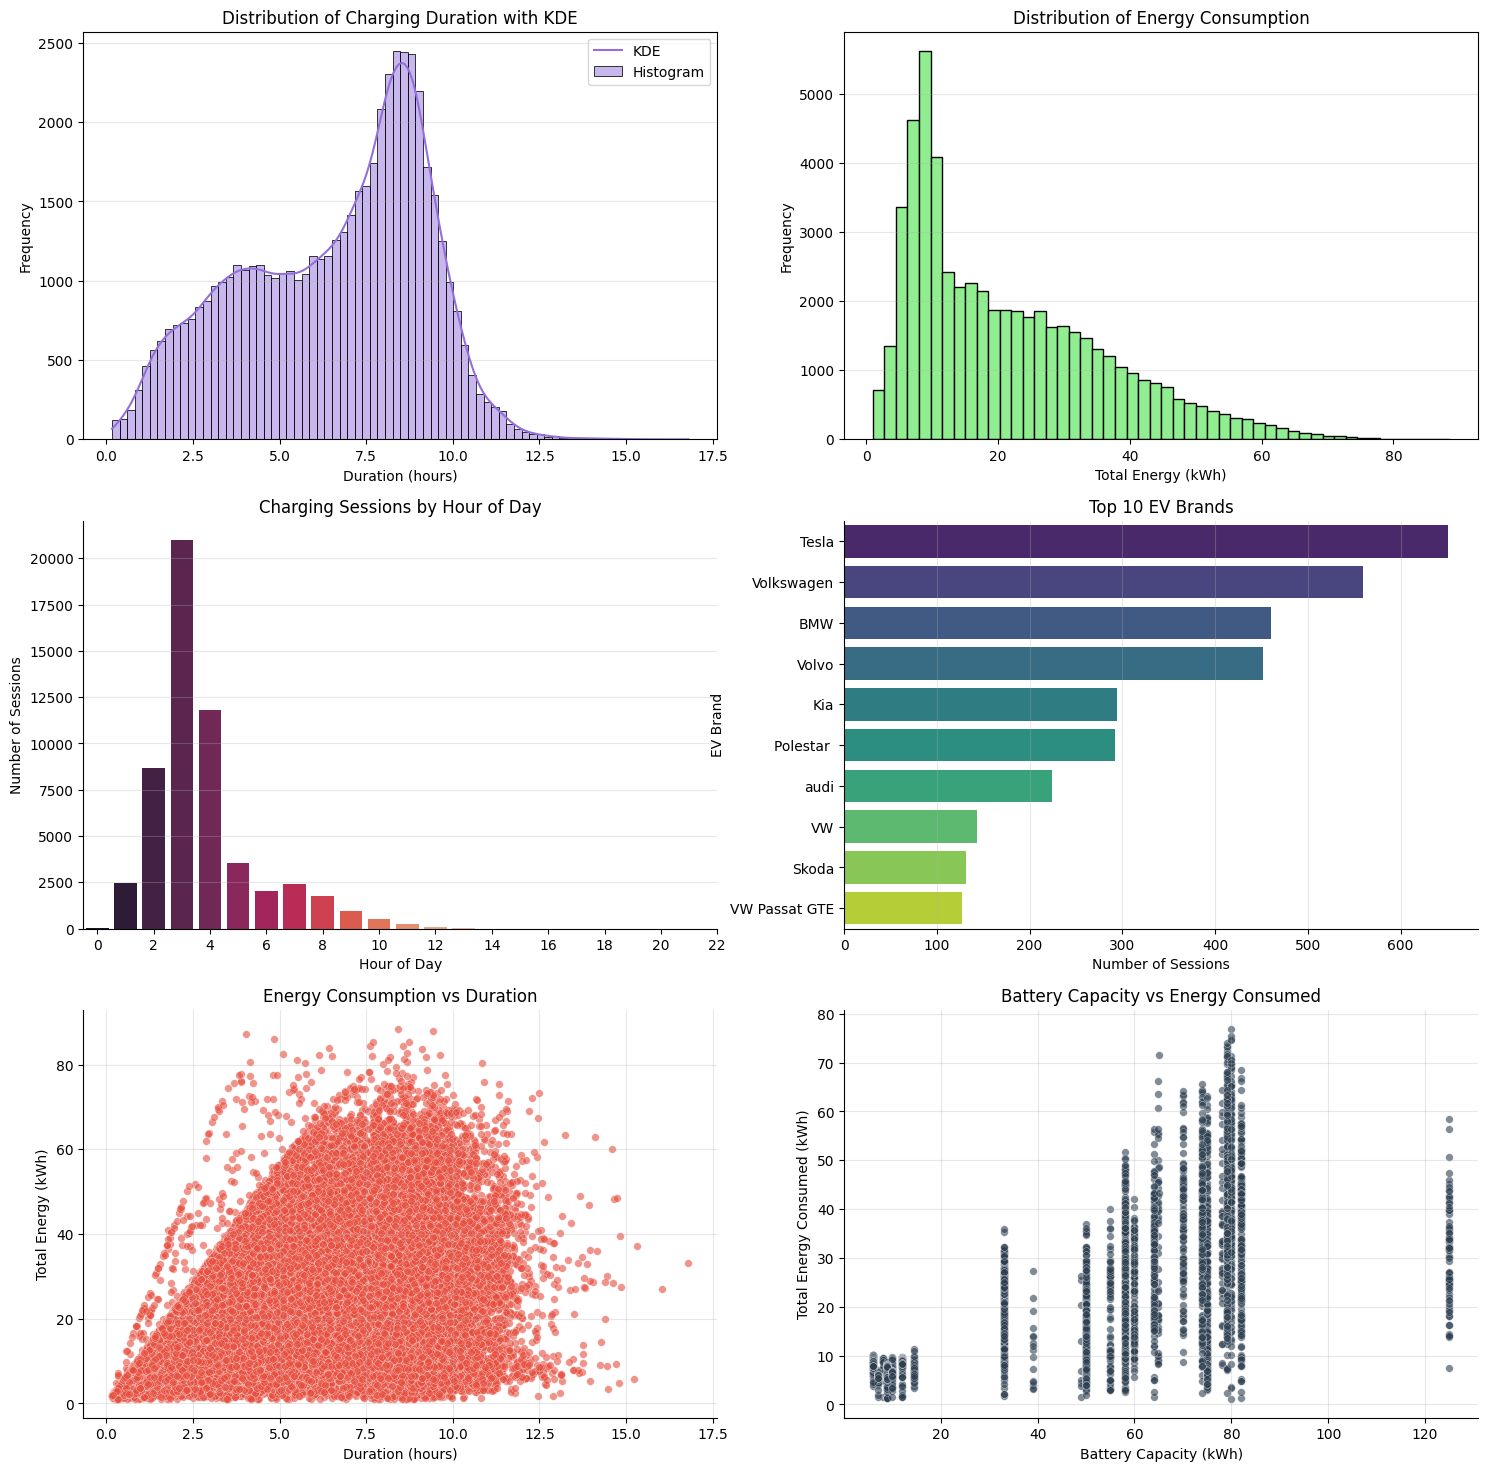

In [6]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# 1. Distribution plot of duration
sns.histplot(data=df, x='duration', kde=True, ax=axes[0, 0], color='mediumpurple', edgecolor='black')
axes[0, 0].set_title('Distribution of Charging Duration with KDE')
axes[0, 0].set_xlabel('Duration (hours)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].legend(['KDE', 'Histogram'])

# 2. Distribution of total energy consumed
axes[0, 1].hist(df['total_energy'], bins=50, edgecolor='black', color='lightgreen')
axes[0, 1].set_xlabel('Total Energy (kWh)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Energy Consumption')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Charging sessions by hour of day
df['start_hour'] = df['start_datetime'].dt.hour
hourly_sessions = df['start_hour'].value_counts().sort_index()

sns.barplot(x=hourly_sessions.index, y=hourly_sessions.values, 
            palette='rocket', ax=axes[1, 0], saturation=0.8)

axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Number of Sessions')
axes[1, 0].set_title('Charging Sessions by Hour of Day')
axes[1, 0].set_xticks(range(0, 24, 2))
axes[1, 0].set_xticklabels(range(0, 24, 2))
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].spines['top'].set_visible(False)
axes[1, 0].spines['right'].set_visible(False)

# 4. Top EV brands
top_brands = df['EV_brand_selfreported'].value_counts().head(10)

sns.barplot(y=top_brands.index, x=top_brands.values, 
            palette='viridis', ax=axes[1, 1], saturation=0.8)

axes[1, 1].set_xlabel('Number of Sessions')
axes[1, 1].set_ylabel('EV Brand')
axes[1, 1].set_title('Top 10 EV Brands')
axes[1, 1].grid(axis='x', alpha=0.3)
axes[1, 1].spines['top'].set_visible(False)
axes[1, 1].spines['right'].set_visible(False)

# 5. Energy vs Duration scatter plot
sns.scatterplot(x='duration', y='total_energy', data=df, 
                alpha=0.6, s=30, color='#e74c3c', 
                edgecolor='white', linewidth=0.3, ax=axes[2, 0])

# Styling
axes[2, 0].set_xlabel('Duration (hours)')
axes[2, 0].set_ylabel('Total Energy (kWh)')
axes[2, 0].set_title('Energy Consumption vs Duration')
axes[2, 0].grid(alpha=0.3)
axes[2, 0].spines['top'].set_visible(False)
axes[2, 0].spines['right'].set_visible(False)

# 6. Capacity vs Total Energy scatter
sns.scatterplot(x='capacity_kwh', y='total_energy', data=df, 
                alpha=0.6, s=30, color='#2c3e50', 
                edgecolor='white', linewidth=0.3, ax=axes[2, 1])

# Styling
axes[2, 1].set_xlabel('Battery Capacity (kWh)')
axes[2, 1].set_ylabel('Total Energy Consumed (kWh)')
axes[2, 1].set_title('Battery Capacity vs Energy Consumed')
axes[2, 1].grid(alpha=0.3)
axes[2, 1].spines['top'].set_visible(False)
axes[2, 1].spines['right'].set_visible(False)

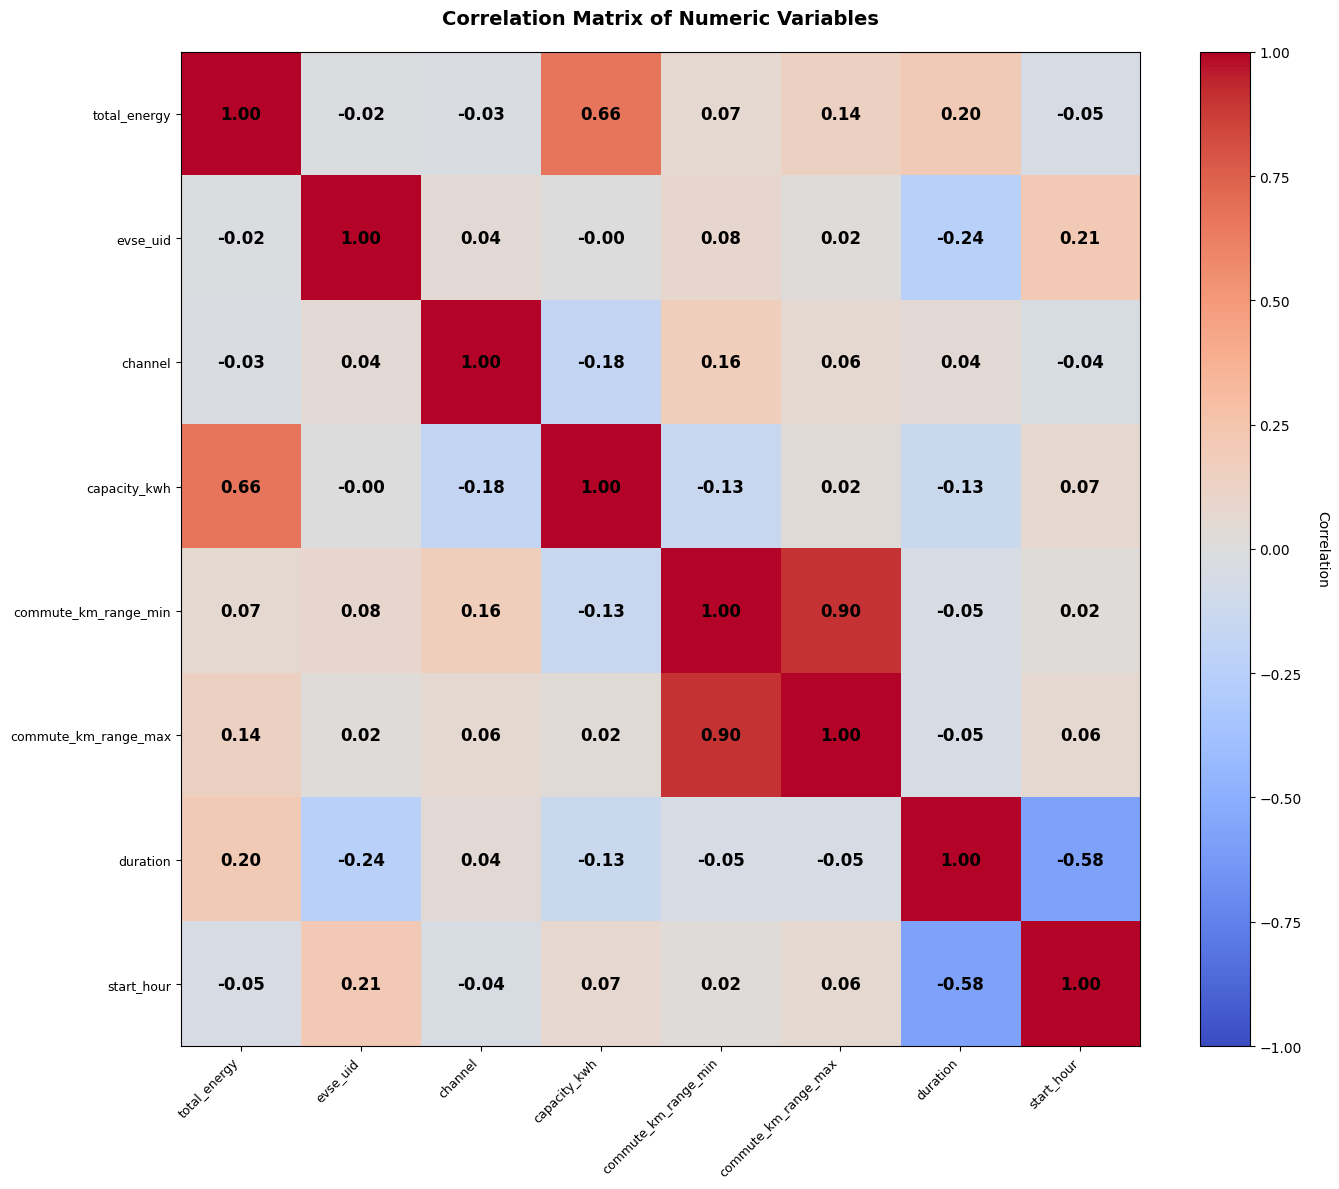


Correlation Matrix:
                      total_energy  evse_uid   channel  capacity_kwh  \
total_energy              1.000000 -0.017904 -0.030334      0.661139   
evse_uid                 -0.017904  1.000000  0.039626     -0.003243   
channel                  -0.030334  0.039626  1.000000     -0.175312   
capacity_kwh              0.661139 -0.003243 -0.175312      1.000000   
commute_km_range_min      0.067862  0.081137  0.164429     -0.134123   
commute_km_range_max      0.139527  0.020937  0.056347      0.023627   
duration                  0.195436 -0.240896  0.044667     -0.126611   
start_hour               -0.049184  0.208371 -0.044234      0.073825   

                      commute_km_range_min  commute_km_range_max  duration  \
total_energy                      0.067862              0.139527  0.195436   
evse_uid                          0.081137              0.020937 -0.240896   
channel                           0.164429              0.056347  0.044667   
capacity_kwh      

In [ ]:
## Correlation Matrix

# Calculate correlation matrix for numeric columns
correlation_matrix = df.select_dtypes(include=['number']).corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 12))

# Create the heatmap using imshow
im = ax.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')

# Set ticks and labels
ax.set_xticks(range(len(correlation_matrix.columns)))
ax.set_yticks(range(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(correlation_matrix.columns, fontsize=9)

# Add text annotations for all values
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        text = ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=12, weight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation', rotation=270, labelpad=20)

ax.set_title('Correlation Matrix of Numeric Variables', fontsize=14, pad=20, weight='bold')
plt.tight_layout()
plt.show()